In [574]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import train_test_split
from math import sqrt

In [575]:
# Загружаем данные
dataset = pd.read_csv("allBank_balance_101_sector.csv", index_col=['report_date'], parse_dates=['report_date'], dayfirst=True)
dataset.head()

,sector_id,bank_group_id,value_rub,value_usd
report_date,,,,
2007-02-01,40,6,9.408740,8.925271
2007-02-01,10,6,31.943854,36.274318
2007-02-01,41,6,48.045392,20.535636
2007-02-01,12,6,4.604419,15.616651
2007-02-01,15,6,0.041111,0.000002


In [576]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215564 entries, 2007-02-01 to 2019-05-01
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sector_id      215564 non-null  int64  
 1   bank_group_id  215564 non-null  int64  
 2   value_rub      215564 non-null  float64
 3   value_usd      215564 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 8.2 MB


In [577]:
# Фильтруем
data_bank = dataset[dataset['bank_group_id'] == 1]
data = data_bank.loc[data_bank['sector_id'].isin([1, 2, 3, 4])]

In [578]:
# Группируем для получения одного временного ряда
rub = data.groupby("report_date").sum()
rub = rub.drop(['sector_id', 'bank_group_id', 'value_usd'], axis=1)

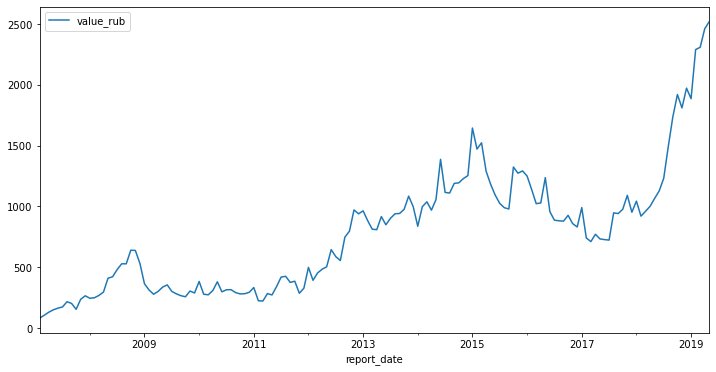

In [579]:
rub.plot(figsize=(12,6))

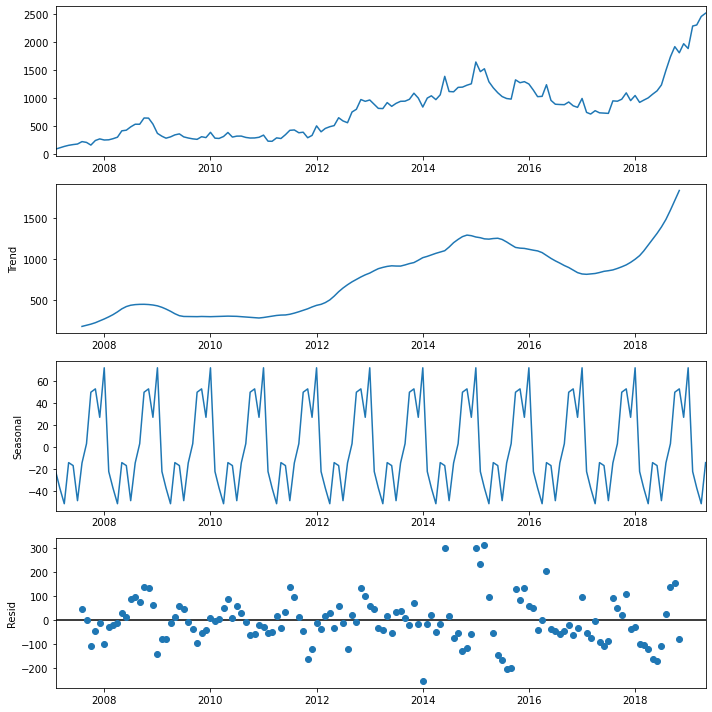

<Figure size 2160x7200 with 0 Axes>

In [652]:
# Декомпозиция
sm.tsa.seasonal_decompose(rub).plot()
res = sm.tsa.seasonal_decompose(rub)
plt.rcParams['figure.figsize'] = (10, 20)
# plt.show()

In [581]:
rub.index.freq = 'MS'
train, test = rub.iloc[:120, 0], rub.iloc[120:, 0]

C:\Users\volon\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\volon\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\volon\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


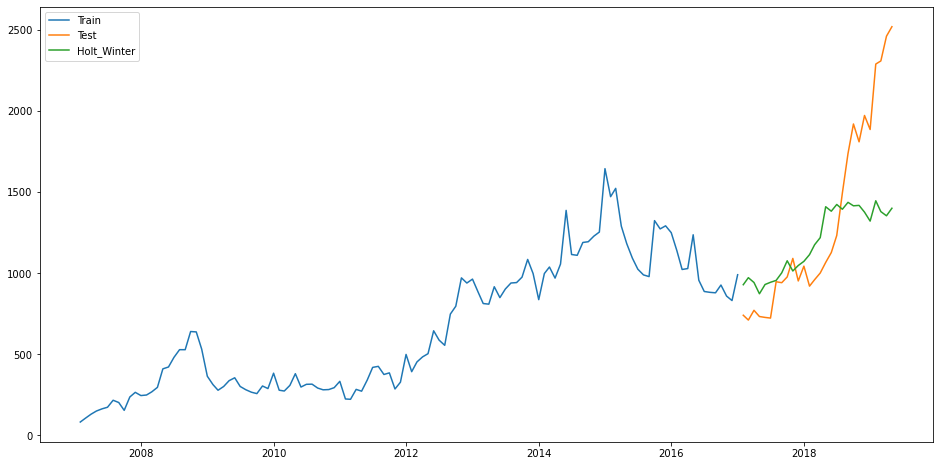

In [629]:
# Метод Холта-Винтера
fit1 = ES(train ,seasonal_periods=40 ,trend='add', seasonal='add',).fit()
pred1 = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred1, label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [630]:
rms1 = sqrt(mean_squared_error(test, pred1))
print(rms1)

457.5202691641317


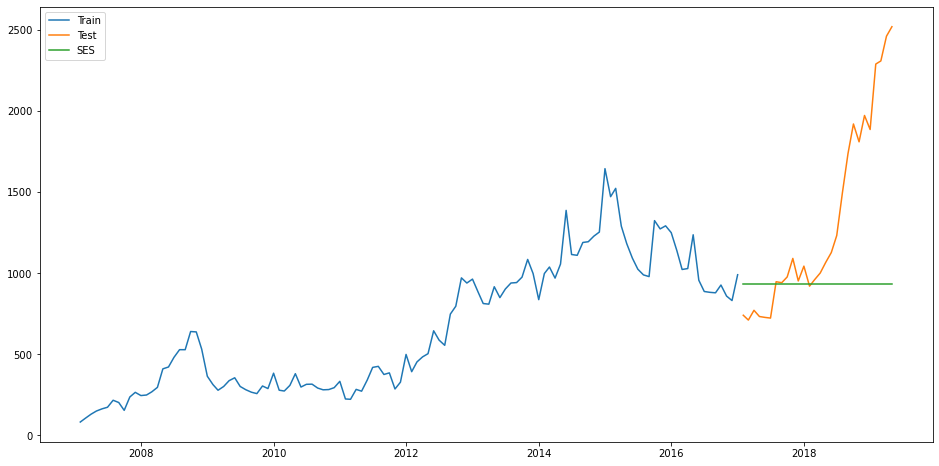

In [585]:
#  Экспоненциальное сглаживание
fit2 = SimpleExpSmoothing(train).fit(smoothing_level=0.6,optimized=False)
pred2 = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred2, label='SES')
plt.legend(loc='best')
plt.show()

In [586]:
rms2 = sqrt(mean_squared_error(test, pred2))
print(rms2)

698.941379874954


C:\Users\volon\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


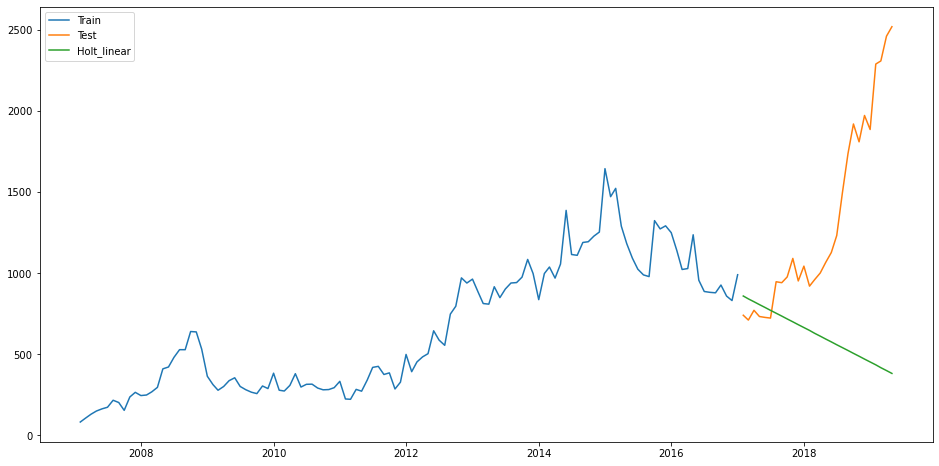

In [587]:
# Метод линейного тренда Холта
fit3 = Holt(train).fit(smoothing_level=0.3,smoothing_slope = 0.1)
pred3 = fit3.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred3, label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [588]:
rms3 = sqrt(mean_squared_error(test, pred3))
print(rms3)

1002.9524408746329


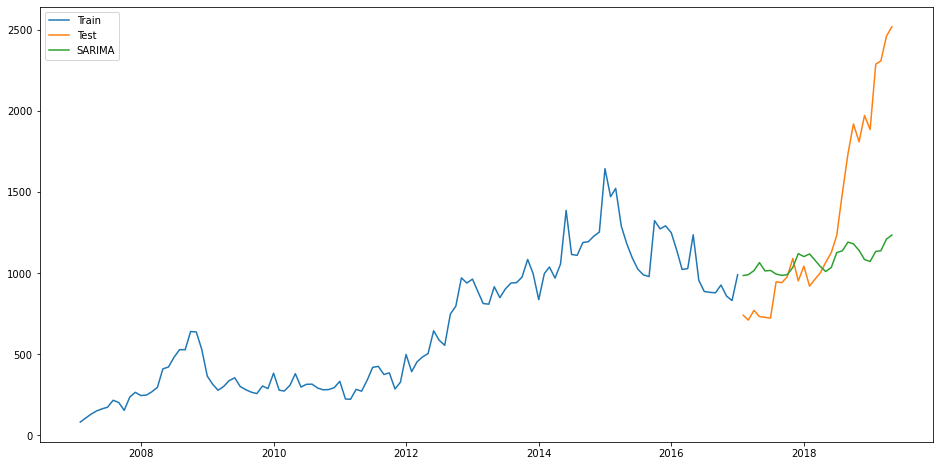

In [596]:
# SARIMAX
fit4 = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
# pred4 = fit1.predict(start=pd.to_datetime("2013-11-1"), end=pd.to_datetime("2015-12-1"))
pred4 = fit4.predict(start="2017-02-1", end="2019-05-01")
# pred4 = fit1.predict(len(test))
plt.figure(figsize=(16,8))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred4, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [597]:
rms4 = sqrt(mean_squared_error(test, pred4))
print(rms4)

579.101233639779


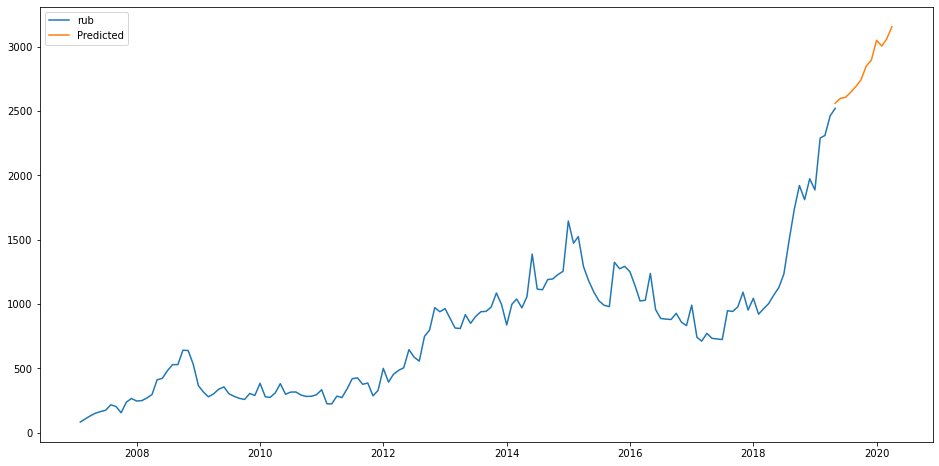

In [646]:
# На основании RMSE выбираем метод Холта-Винтера повторно тренируем всю выборку до разделения
fit = ES(rub ,seasonal_periods=40 ,trend='add', seasonal='add',).fit()

predicted = fit.predict(start="2019-05-01", end="2020-04-01")

plt.figure(figsize=(16,8))
plt.plot(rub, label='rub')
plt.plot(prediction, label='Predicted')
plt.legend(loc='best')
plt.show()

In [644]:
predicted.shape

(12,)

In [645]:
predicted

2019-05-01    2560.161054
2019-06-01    2598.822948
2019-07-01    2605.571448
2019-08-01    2645.715716
2019-09-01    2690.712904
2019-10-01    2742.375681
2019-11-01    2849.637477
2019-12-01    2894.062443
2020-01-01    3049.166424
2020-02-01    3004.563193
2020-03-01    3059.819819
2020-04-01    3155.056321
Freq: MS, dtype: float64